In [27]:
import numpy as np
from firedrake import *
import matplotlib.pyplot as plt

In [10]:
from numba import njit, float64, int64

In [11]:
@njit
def monomials(x, order=1):
    """
    Return Vandermonde matrix. In 2D, with order p, :math:`V = [1, x, y]`.
    """
    if order == 1:
        return np.array([1.0, x[0], x[1]])
    elif order == 2:
        if x.shape[0] == 2:
            return np.array([1.0, x[0], x[1], x[0]*x[0], x[0]*x[1], x[1]*x[1]])
    # else:
    #     raise NotImplementedError

In [12]:

def make_consistent(mesh, h_mesh=None):
    """
    Make the coordinates associated with a Firedrake mesh and its underlying PETSc DMPlex
    use a consistent numbering.

    :kwarg h_mesh: uniformly refined mesh for if base mesh is not linear.
    """
    import firedrake.cython.dmcommon as dmplex

    if h_mesh is not None:
        assert len(mesh.coordinates.dat.data) == len(h_mesh.coordinates.dat.data)

    # Create section
    dim = mesh.topological_dimension()
    gdim = mesh.geometric_dimension()
    entity_dofs = np.zeros(dim+1, dtype=np.int32)
    entity_dofs[0] = gdim
    P0 = FunctionSpace(mesh, "DG", 0)  # NOQA
    coord_section = dmplex.create_section(h_mesh or mesh, entity_dofs)

    # Set plex coords to mesh coords
    mesh = h_mesh or mesh
    try:
        plex = mesh.topology_dm
    except AttributeError:
        plex = mesh._topology_dm  # Backwards compatibility
    dm_coords = plex.getCoordinateDM()
    dm_coords.setDefaultSection(coord_section)
    coords_local = dm_coords.createLocalVec()
    coords_local.array[:] = np.reshape(mesh.coordinates.dat.data, coords_local.array.shape)
    plex.setCoordinatesLocal(coords_local)

    # Functions for getting offsets of entities and coordinates of vertices
    offset = lambda index: coord_section.getOffset(index)//dim
    coordinates = lambda index: mesh.coordinates.dat.data[offset(index)]
    return plex, offset, coordinates


def get_patch(vertex, mesh=None, plex=None, coordinates=None, midfacets=False, extend=None):
    """
    Generate an element patch around a vertex.

    :kwarg extend: optionally take the union with an existing patch.
    """
    if extend is None:
        elements = set([])
        facets = set([])
    else:
        elements = set(extend['elements'].keys())
        facets = set(extend['facets'].keys())
    if coordinates is None:
        assert mesh is not None
        plex, offset, coordinates = make_consistent(mesh)
    if plex is None:
        try:
            plex = mesh.topology_dm
        except AttributeError:
            plex = mesh._topology_dm  # Backwards compatibility
    dim = plex.getDimension()
    assert dim in (2, 3)
    if mesh is not None:
        cell = mesh.ufl_cell()
        if (dim == 2 and cell != triangle) or (dim == 3 and cell != tetrahedron):
            raise ValueError("Element type {:} not supported".format(cell))

    # Get patch of neighbouring elements
    for e in plex.getSupport(vertex):
        elements = elements.union(set(plex.getSupport(e)))
    patch = {'elements': {k: {'vertices': []} for k in elements}}

    # Get vertices, facets and centroids in patch
    all_vertices = set(range(*plex.getDepthStratum(0)))
    all_facets = set(range(*plex.getDepthStratum(1)))
    patch['vertices'] = set([])
    patch_facets = set([])
    for k in elements:
        closure = set(plex.getTransitiveClosure(k)[0])
        patch['elements'][k]['vertices'] = all_vertices.intersection(closure)
        patch['elements'][k]['facets'] = all_facets.intersection(closure)
        patch_facets = patch_facets.union(patch['elements'][k]['facets'])
        coords = [coordinates(v) for v in patch['elements'][k]['vertices']]
        patch['elements'][k]['centroid'] = np.sum(coords, axis=0)/(dim + 1)
        patch['vertices'] = patch['vertices'].union(set(patch['elements'][k]['vertices']))
    patch_facets.union(facets)
    patch['facets'] = {e: {} for e in patch_facets}

    # Get facet centroids
    if midfacets:
        for e in patch['facets']:
            closure = set(plex.getTransitiveClosure(e)[0])
            patch['facets'][e] = {'vertices': all_vertices.intersection(closure)}
            coords = [coordinates(v) for v in plex.getCone(e)]
            patch['facets'][e]['midfacet'] = np.sum(coords, axis=0)/dim

    return patch

In [13]:
@njit
def prod(arr):
    """
    Helper function for taking the product of an array (similar to `sum`).
    """
    n = arr.shape[0]
    if n == 0:
        raise ValueError
    elif n == 1:
        return arr[0]
    else:
        return arr[0]*prod(arr[1:])

In [14]:
def recover_zz(f, to_recover='gradient', **kwargs):
    """
    Recover the gradient of a :class:`Function` `f` using the approach of [Zienkiewicz and Zhu 1987].
    Note that `f` can be either a scalar or a vector function. In the latter case, the recovered
    gradient is a matrix function.

    If :kwarg:`to_recover` is set to 'field' then the field itself is recovered in a higher order
    space, as opposed to its gradient being recovered in the same order space.

    NOTE that P2 approximations tend to break down on axis-aligned uniform meshes. However, a minor
    rotation of the axes should be sufficient to fix it.

    :kwarg tolerance: see point evaluation method :attr:`at` for :class:`Function`.
    :kwarg alpha: distance to point evaluate to one side of a facet, as a fraction of the distance
        from mid-facet to element centroid.
    :kwarg weight: weighting for facets which do not support the vertex in question (only relevant
        for recovery in P2 space).
    """
    tol = kwargs.get('tolerance', None)
    alpha = kwargs.get('alpha', 1.0e-08)
    weight = kwargs.get('weight', 1.0)
    assert to_recover in ('field', 'gradient')
    fs = f.function_space()
    p = fs.ufl_element().degree()
    if to_recover == 'gradient':
        assert p > 0
    elif to_recover == 'field':
        p += 1
    if p not in (1, 2):
        raise NotImplementedError
    mesh = fs.mesh()
    dim = mesh.topological_dimension()
    if p == 2:
        h_mesh = kwargs.get('h_mesh') or MeshHierarchy(mesh, 1)[1]
    plex, offset, coordinates = make_consistent(mesh)

    # Construct FunctionSpaces for the direct and recovered gradients
    shape = len(fs.shape)
    if to_recover == 'field':
        assert shape in (0, 1, 2)
        constructor = FunctionSpace if shape == 0 else VectorFunctionSpace if shape == 1 else TensorFunctionSpace
    else:
        assert shape in (0, 1)
        constructor = VectorFunctionSpace if shape == 0 else TensorFunctionSpace
    Pp_ = constructor(mesh, "DG", p-1)
    Pp = constructor(mesh, "CG", p)
    if to_recover == 'gradient':
        shape = [dim for i in range(shape+1)]
    else:
        shape = [1] if shape == 0 else [dim for i in range(shape)]
    
    shape = np.array(shape)
    # Create Functions to hold the direct and recovered fields/gradients
    sigma_h = interpolate(f if to_recover == 'field' else grad(f), Pp_)
    sigma_ZZ = Function(Pp)

    # Create a higher order mesh in order to get offsets for non-vertex nodes in P2 space
    if p == 2:
        p_mesh = Mesh(interpolate(mesh.coordinates, VectorFunctionSpace(mesh, "CG", 2)))
        p_plex, p_offset, p_coordinates = make_consistent(p_mesh, h_mesh)

    # Loop over all vertices
    kwargs = dict(plex=plex, coordinates=coordinates, midfacets=p == 2)
    bnodes = DirichletBC(Pp, 0, 'on_boundary').nodes
    for vvv in range(*plex.getDepthStratum(0)):
        patch = get_patch(vvv, **kwargs)
        vvv_facets = set(plex.getSupport(vvv))

        # Extend patch for corner case
        if len(patch['elements'].keys()) <= 2 if dim == 2 else 6:
            for v in patch['vertices']:
                if v != vvv and offset(v) in bnodes:
                    patch = get_patch(v, extend=patch, **kwargs)
                    break

        # Extend patch for boundary case
        if offset(vvv) in bnodes:
            for v in patch['vertices']:
                if offset(v) not in bnodes:
                    patch = get_patch(v, extend=patch, **kwargs)
                    break

        # TODO: Add condition for interior patches with insufficient DOFs

        # Assemble local system
        if p == 1:
            N = 1 + dim
            A = np.zeros((N, N))
            b = np.zeros((N, prod(shape)))
            for k in patch['elements']:
                c = patch['elements'][k]['centroid']
                P = monomials(c)
                A += np.tensordot(P, P, axes=0)
                b += np.tensordot(P, sigma_h.at(c, tolerance=tol).flatten(), axes=0)
        elif p == 2:
            # NOTE: If the source field is P1DG then the midfacet values are not well-defined.
            #       Therefore, we take the value just to one side, as specified by alpha.
            N = 1 + dim + dim*(dim + 1)//2
            A = np.zeros((N, N))
            b = np.zeros((N, prod(shape)))
            for k in patch['elements']:
                c = patch['elements'][k]['centroid']
                for e in patch['elements'][k]['facets']:
                    w = 1 if e in vvv_facets else weight
                    m = (1-alpha)*patch['facets'][e]['midfacet'] + alpha*c
                    m = np.array(m)
                    P = monomials(m, 2)
                    A += w*np.tensordot(P, P, axes=0)
                    b += w*np.tensordot(P, sigma_h.at(m, tolerance=tol).flatten(), axes=0)

        # Solve local system and insert where appropriate
        a = np.linalg.solve(A, b)
        if p == 1:
            interpolant = lambda vtx: np.dot(monomials(coordinates(vtx)), a).reshape(shape)
            sigma_ZZ.dat.data[offset(vvv)] = interpolant(vvv)
        elif p == 2:
            zero = np.zeros(shape)
            interpolant = lambda vtx: np.dot(monomials(p_coordinates(vtx), 2), a).reshape(shape)
            assert dim == 2  # TODO
            vvv_coords = coordinates(vvv)
            immediate_midfacets = [0.5*(vvv_coords + coordinates(v)) for v in patch['vertices']]
            # FIXME: HACKY IMPLEMENTATION
            #        ====================
            #        * This code loops over midfacets and all nodes and determines if they lie
            #          are adjacent to the vertex by comparing coordinates.
            #        * A cleaner implementation requires knowledge of which nodes lie in the patch.
            for c in immediate_midfacets:
                for node in range(*p_plex.getDepthStratum(0)):  # FIXME: HACKY!
                    if np.allclose(c, p_coordinates(node)):
                        off = p_offset(node)
                        if np.allclose(sigma_ZZ.dat.data[off], zero):
                            sigma_ZZ.dat.data[off] = interpolant(node)
                        else:
                            sigma_ZZ.dat.data[off] = 0.5*(interpolant(node) + sigma_ZZ.dat.data[off])
                        break
    return sigma_ZZ

In [25]:
u_grad_diffs = []
u_grad_exacts = []
u_grad_zzs = []
for i in range (10,101,10):
    # Define mesh and function space
    mesh = UnitSquareMesh(i, i)
    P1 = FunctionSpace(mesh, 'CG', 1)
    P1_vec = VectorFunctionSpace(mesh, 'CG', 1)

    x, y = SpatialCoordinate(mesh)
    # Define analytical solution and right-hand side
    u_exact = Function(P1).interpolate(cos(2*pi*x)*cos(2*pi*y))
    f = Function(P1)
    f.interpolate((1+8*pi*pi)*cos(x*pi*2)*cos(y*pi*2))

    # Define variational problem
    u = TrialFunction(P1)
    v = TestFunction(P1)
    a = dot(grad(u), grad(v))*dx + u*v*dx
    L = f*v*dx

    # Compute solution for Poisson equation
    u_sol = Function(P1)
    solve(a == L, u_sol)
    # Calculate analytical gradient of u
    u_grad_exact_expr = as_vector([-2 * pi * sin(2 * pi * x) * cos(2 * pi * y),
                                    -2 * pi * cos(2 * pi * x) * sin(2 * pi * y)])
    u_grad_exact = project(u_grad_exact_expr, P1_vec)
    u_grad_exacts.append(u_grad_exact)
    
    u_grad_zz = recover_zz(u_sol)
    u_grad_zzs.append(u_grad_zz)
    # Compute the magnitudes of the gradients
    u_grad_diff = errornorm(u_grad_exact,u_grad_zz)
    print(f"The global error is %.8f" % (u_grad_diff) + " " + f"for {i}x{i} Mesh")
    u_grad_diffs.append(u_grad_diff)

The global error is 1.12513557 for 10x10 Mesh
The global error is 0.33980902 for 20x20 Mesh
The global error is 0.15871954 for 30x30 Mesh
The global error is 0.09122034 for 40x40 Mesh
The global error is 0.05916388 for 50x50 Mesh
The global error is 0.04145510 for 60x60 Mesh
The global error is 0.03066918 for 70x70 Mesh
The global error is 0.02361821 for 80x80 Mesh
The global error is 0.01875045 for 90x90 Mesh
The global error is 0.01525696 for 100x100 Mesh


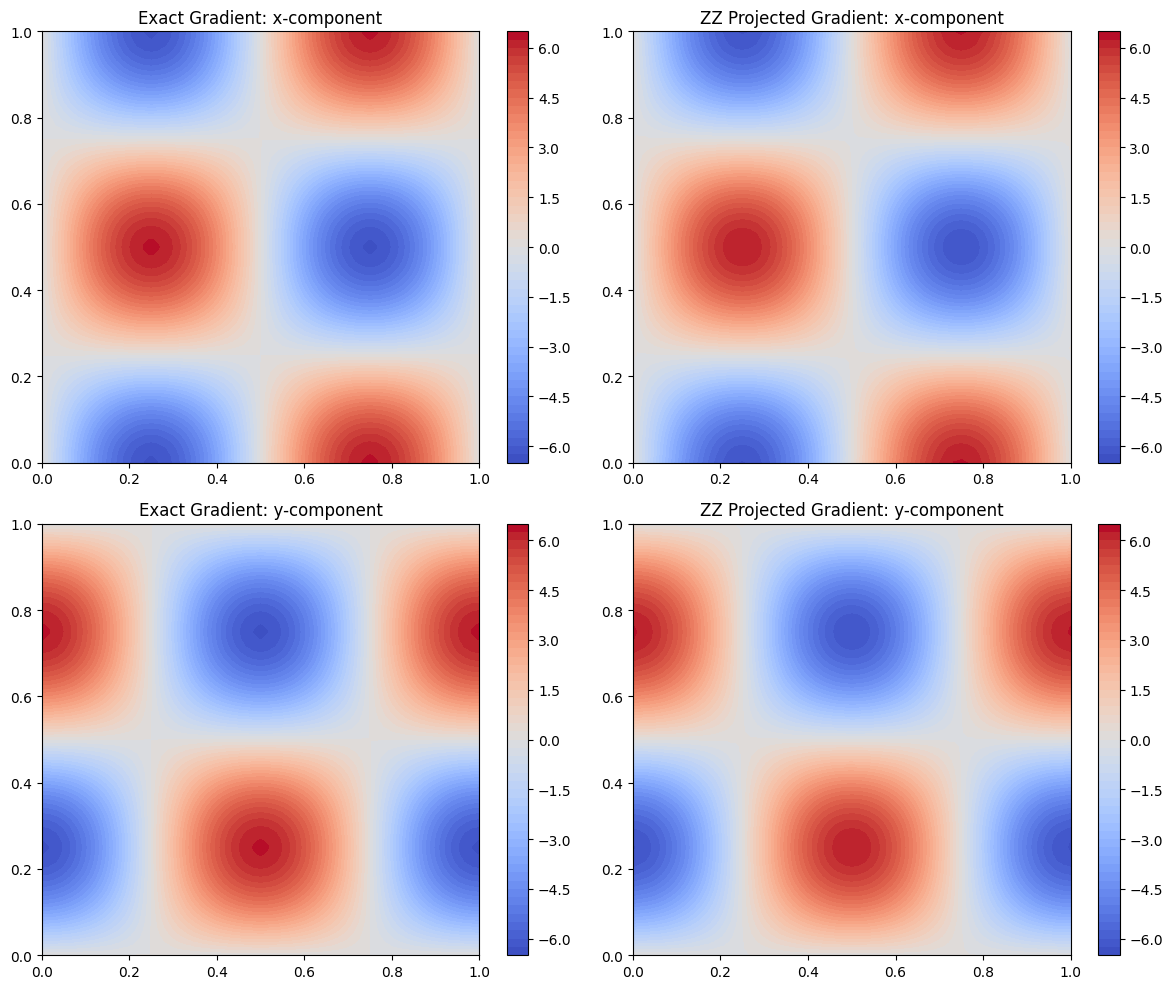

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the x-component of the exact gradient
axes[0,0].set_title("Exact Gradient: x-component")
contour = tricontourf(u_grad_exacts[5].sub(0), axes=axes[0,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])

# Plot the x-component of the L2 projected gradient
axes[0,1].set_title("ZZ Projected Gradient: x-component")
contour = tricontourf(u_grad_zzs[5].sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])

# Plot the x-component of the exact gradient
axes[1,0].set_title("Exact Gradient: y-component")
contour = tricontourf(u_grad_exacts[5].sub(1), axes=axes[1,0], levels=50,cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])

# Plot the x-component of the L2 projected gradient
axes[1,1].set_title("ZZ Projected Gradient: y-component")
contour = tricontourf(u_grad_zzs[5].sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

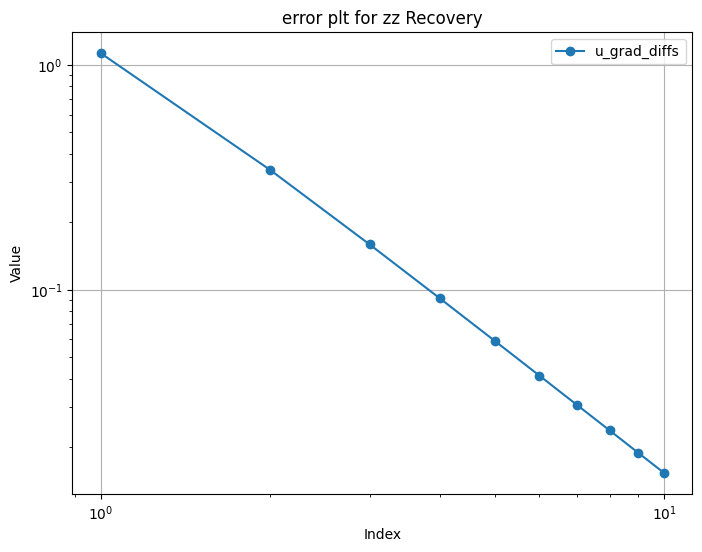

In [ ]:
# Plotting
# Assuming linear spacing for nodes/elements
elements = np.linspace(1, 10, 10)
plt.figure(figsize=(8, 6))

plt.plot(elements, u_grad_diffs, '-o', label="u_grad_diffs")

# Adding title and labels
plt.title("error plt for zz Recovery")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.yscale("log")  # if you want a logarithmic scale for residuals
plt.xscale("log")
# Show plot
plt.grid(True)
plt.show()

For CG1: log(e(h)) = -1.8836289317494033 * log(h) + 4.522662578214993


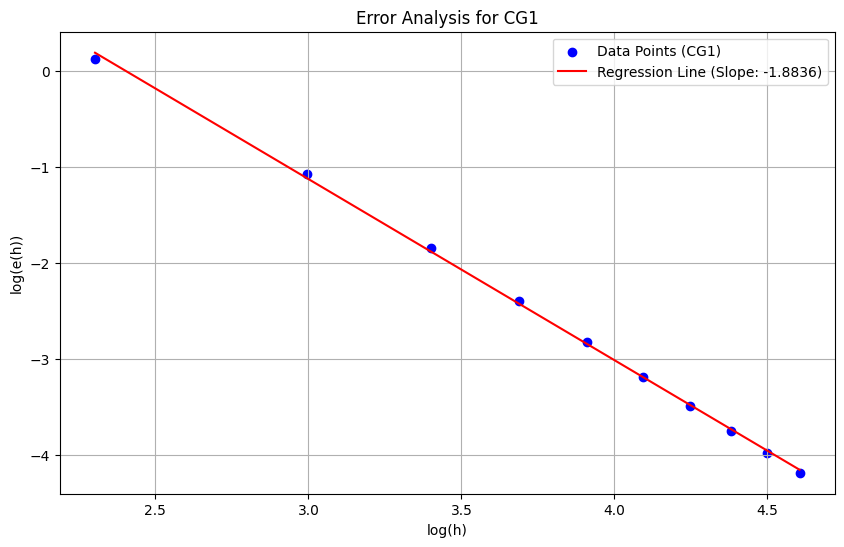

In [ ]:
from scipy.stats import linregress

# Given data for CG1
mesh_sizes = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
errors = u_grad_diffs

# Compute log-log values
log_mesh_sizes = np.log(mesh_sizes)
log_errors = np.log(errors)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_mesh_sizes, log_errors)

print(f"For CG1: log(e(h)) = {slope} * log(h) + {intercept}")

# Visualize the regression
plt.figure(figsize=(10,6))
plt.scatter(log_mesh_sizes, log_errors, color='blue', label='Data Points (CG1)')
plt.plot(log_mesh_sizes, slope*log_mesh_sizes + intercept, color='red', label=f'Regression Line (Slope: {slope:.4f})')
plt.xlabel('log(h)')
plt.ylabel('log(e(h))')
plt.title('Error Analysis for CG1')
plt.legend()
plt.grid(True)
plt.show()


The following tests are used for singularity tests.

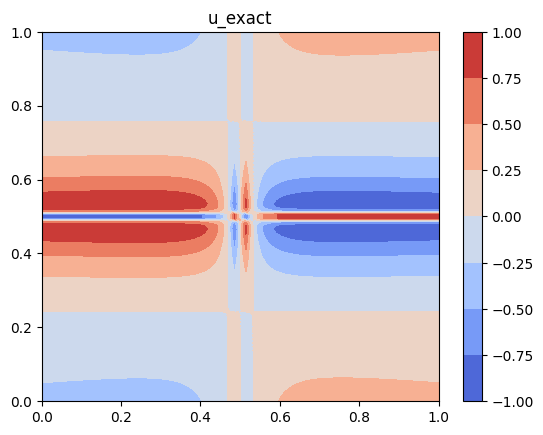

In [48]:
# Create a mesh and define function spaces
mesh = UnitSquareMesh(103, 103)
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)
x, y = SpatialCoordinate(mesh)

epsilon = 1e-10
# Compute the analytical gradient
u_exact = Function(P1).interpolate(sin(pow(x-0.5, -1./3.))*cos(pow(y-0.5, -1./3.)))
u_grad_ZZ = recover_zz(u_exact)

# Calculate analytical gradient of u
u_grad_exact_expr = as_vector([-cos((x - 0.5)**(-1/3))*cos((y - 0.5)**(-1/3))/(3*(x - 0.5)**(4/3)),
                                sin((x - 0.5)**(-1/3))*sin((y - 0.5)**(-1/3))/(3*(y - 0.5)**(4/3))])
u_grad_exact = project(u_grad_exact_expr, P1_vec)

fig, axes = plt.subplots()
u_plt = tricontourf(u_exact, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_exact")
plt.show()


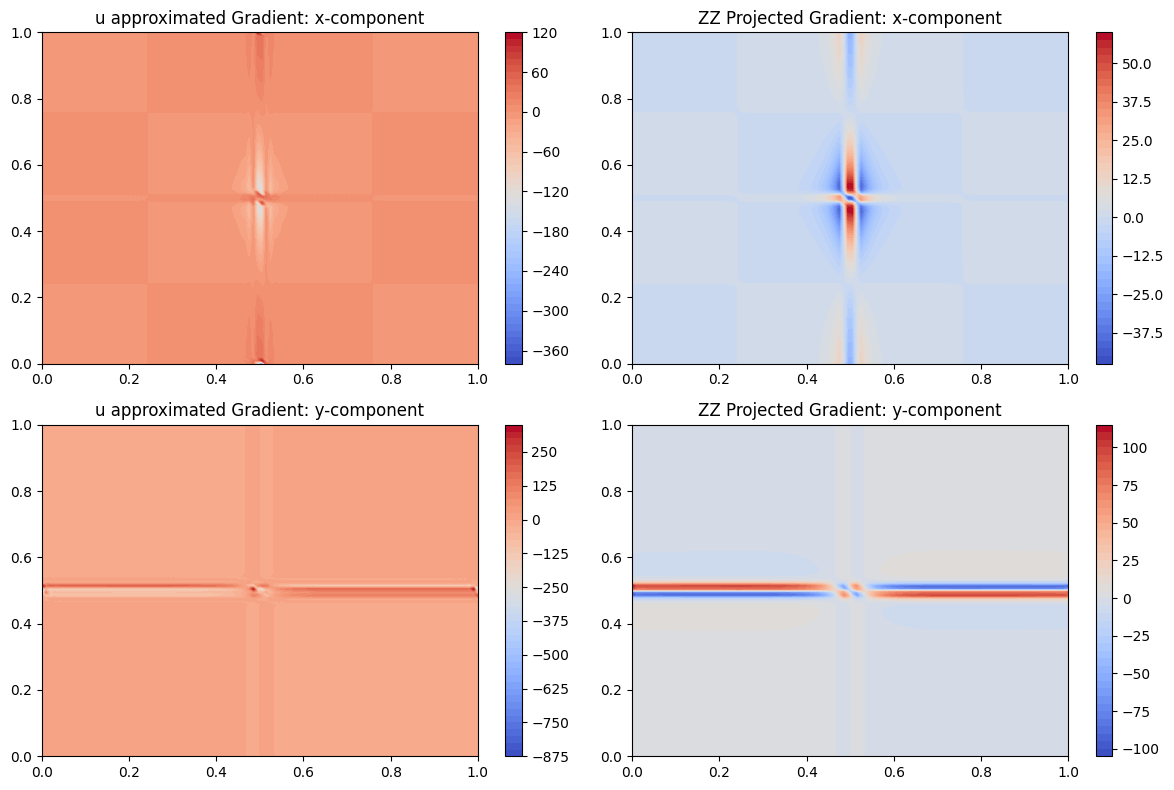

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].set_title("u approximated Gradient: x-component")
contour = tricontourf(u_grad_exact.sub(0), axes=axes[0,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])


axes[0,1].set_title("ZZ Projected Gradient: x-component")
contour = tricontourf(u_grad_ZZ.sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])


axes[1,0].set_title("u approximated Gradient: y-component")
contour = tricontourf(u_grad_exact.sub(1), axes=axes[1,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])



axes[1,1].set_title("ZZ Projected Gradient: y-component")
contour = tricontourf(u_grad_ZZ.sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [50]:
u_grad_diff = errornorm(u_grad_exact,u_grad_ZZ)
print("The global error is %.10f" % (u_grad_diff))

The global error is 21.0965294181


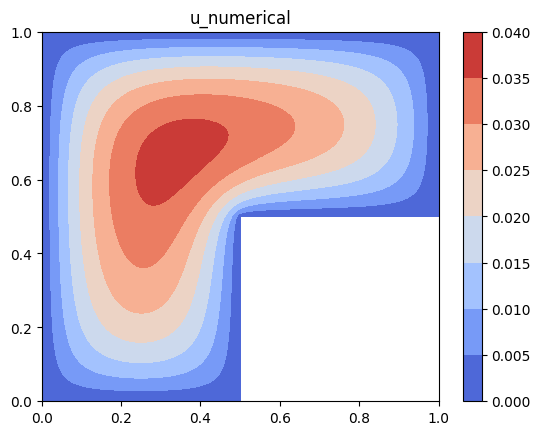

In [53]:
mesh = Mesh("lshape2.msh")
P1 = FunctionSpace(mesh, 'CG', 1)
P1_vec = VectorFunctionSpace(mesh, 'CG', 1)
x, y = SpatialCoordinate(mesh)
v = TestFunction(P1)
u = Function(P1)

f = Function(P1).interpolate(Constant(1))
bc = DirichletBC(P1, Constant(0.0), "on_boundary")

F = (dot(grad(u), grad(v)) - inner(f, v)) * dx
solve(F == 0, u, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bc)

fig, axes = plt.subplots()
u_plt = tricontourf(u, axes=axes, cmap='coolwarm')
fig.colorbar(u_plt)
plt.title("u_numerical")
plt.show()

In [54]:
mesh_highres = Mesh("lshape2.msh")
P1_highres = FunctionSpace(mesh_highres, 'CG', 6)
P1_vec_highres = VectorFunctionSpace(mesh_highres, 'CG', 6)
x, y = SpatialCoordinate(mesh_highres)
v = TestFunction(P1_highres)
u_highres = Function(P1_highres)

f = Function(P1_highres).interpolate(Constant(1))
bc = DirichletBC(P1_highres, Constant(0.0), "on_boundary")

F = (dot(grad(u_highres), grad(v)) - inner(f, v)) * dx
solve(F == 0, u_highres, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'}, bcs=bc)
u_highres_grad = grad(u_highres)
u_highres_grad_projected = project(u_highres_grad, P1_vec_highres)

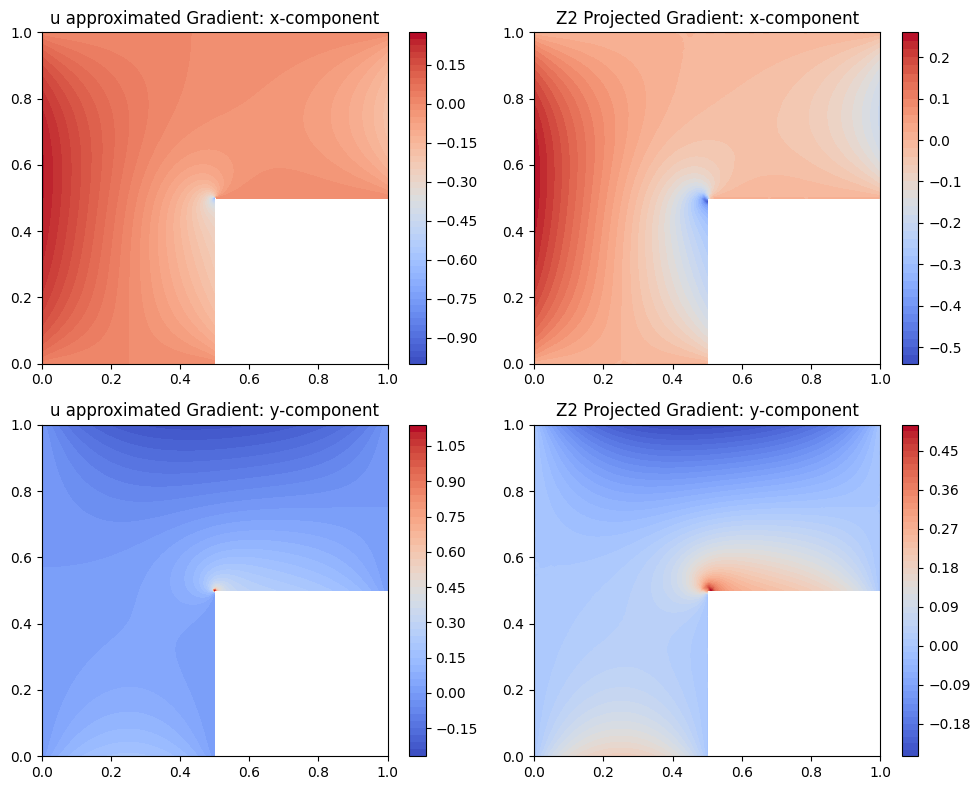

In [55]:
# Compare L2 projected gradient with analytical gradient
u_grad_ZZ = recover_zz(u)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


axes[0,0].set_title("u approximated Gradient: x-component")
contour = tricontourf(u_highres_grad_projected.sub(0), axes=axes[0,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,0])


axes[0,1].set_title("Z2 Projected Gradient: x-component")
contour = tricontourf(u_grad_ZZ.sub(0), axes=axes[0,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[0,1])


axes[1,0].set_title("u approximated Gradient: y-component")
contour = tricontourf(u_highres_grad_projected.sub(1), axes=axes[1,0], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,0])



axes[1,1].set_title("Z2 Projected Gradient: y-component")
contour = tricontourf(u_grad_ZZ.sub(1), axes=axes[1,1], levels=50, cmap='coolwarm')
plt.colorbar(contour, ax=axes[1,1])

plt.tight_layout()
plt.show()